A notebook to test and demonstrate `KernelSteinTest`. This implements the kernelized Stein discrepancy test of Chwialkowski et al., 2016 and Liu et al., 2016 in ICML 2016.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kgof
import kgof.data as data
import kgof.density as density
import kgof.goftest as gof
import kgof.kernel as ker
import kgof.util as util
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

--------------

## Problem: p = Isotropic normal distribution

In [3]:
# true p
seed = 13
d = 15
# sample
n = 800

mean = np.zeros(d)
variance = 1.0
qmean = mean.copy()
qmean[0] = 0
qvariance = variance

p = density.IsotropicNormal(mean, variance)
# ds = data.DSIsotropicNormal(qmean, qvariance)
ds = data.DSLaplace(d=d, loc=0, scale=1.0/np.sqrt(2))
dat = ds.sample(n, seed=seed+1)
X = dat.data()

In [4]:
# Test
alpha = 0.01

# Gaussian kernel with median heuristic
sig2 = util.meddistance(X, subsample=1000)**2
k = ker.KGauss(sig2)

# inverse multiquadric kernel
# From Gorham & Mackey 2017 (https://arxiv.org/abs/1703.01717)
# k = ker.KIMQ(b=-0.5, c=1.0)

bootstrapper = gof.bootstrapper_rademacher
kstein = gof.KernelSteinTest(p, k, bootstrapper=bootstrapper, 
                             alpha=alpha, n_simulate=500, seed=seed+1)

In [5]:
kstein_result = kstein.perform_test(dat, return_simulated_stats=True,
                                   return_ustat_gram=True)
kstein_result

{'H': array([[ 24.3955048 ,   1.16429402,   5.53141856, ...,  -1.79440993,
           3.30543938,  -1.72950896],
        [  1.16429402,   6.81789084,  -1.63632022, ...,  -1.35011428,
          -0.95864353,  -2.08752081],
        [  5.53141856,  -1.63632022,  17.78570211, ...,   0.98097489,
           1.02091464,   1.84777165],
        ..., 
        [ -1.79440993,  -1.35011428,   0.98097489, ...,  12.72830787,
          -0.46460985,  -0.24953094],
        [  3.30543938,  -0.95864353,   1.02091464, ...,  -0.46460985,
           7.38288921,   0.57255429],
        [ -1.72950896,  -2.08752081,   1.84777165, ...,  -0.24953094,
           0.57255429,   9.50085316]]),
 'alpha': 0.01,
 'h0_rejected': False,
 'n_simulate': 500,
 'pvalue': 0.028000000000000001,
 'sim_stats': array([ 16.48380754,  16.52109459,  21.14538946,  13.87290867,
         11.76535421,  18.57220372,  12.92543967,  12.75464791,
         18.60970128,  18.79292537,  16.77670433,  11.35565248,
         14.83265696,  11.69112623

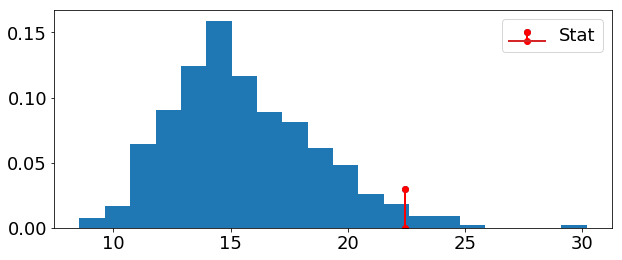

In [6]:
sim_stats = kstein_result['sim_stats']
plt.figure(figsize=(10, 4))
plt.hist(sim_stats, bins=20, normed=True);
plt.stem([kstein_result['test_stat']], [0.03], 'r-o', label='Stat')
plt.legend()
plt.show()

In [34]:
sd_kgof = kstein.compute_stat(dat)
print("SD =", sd_kgof)

SD = 22.4396333556


# Theano implementation
by Aleksandar Botev

In [15]:
import theano.tensor as T
import theano
from theano.gradient import disconnected_grad
theano.config.floatX = "float64"
theano.config.warn_float64 = "ignore"
from scipy.stats import norm

## Theano Gaussian pdf

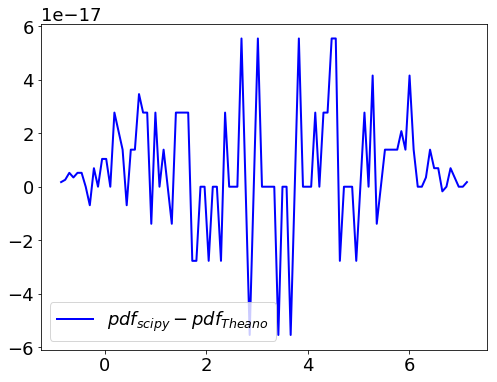

In [22]:
def floatX(var):
    return T.cast(var, theano.config.floatX)

def log_pdf_isotropic_gaussian(x, mean, variance):
    d = floatX(x.shape[1])
    neg_log_pdf2 = T.sum((x - mean.dimshuffle('x', 0))**2, axis=1) / variance
    neg_log_pdf2 += d * T.log(np.pi * 2.0)
    neg_log_pdf2 += d * T.log(variance)
    return - neg_log_pdf2 / 2.0

def test_log_pdf():
    x = np.linspace(np.pi - 4, np.pi + 4, 100).reshape((-1, 1))
    mu = floatX(np.asarray([np.pi]))
    var = floatX(np.asarray([2.0]))
    pdf = T.exp(log_pdf_isotropic_gaussian(floatX(x), mu, var)).flatten().eval()
    np_pdf = norm.pdf(x, np.pi, np.sqrt(2.0)).flatten()
    plt.figure(figsize=(8, 6))
    plt.plot(x, np_pdf - pdf, 'b')
    plt.legend(["$pdf_{scipy} - pdf_{Theano}$"])
    plt.show()

test_log_pdf()

## Function to calculate all pairwise distance in batch mode

In [28]:
def squared_distance_matrix(x, y, return_dim3=True):
    """
    Returns the matrix `M` of pairwise squared distance between x and y:
    M_{i,j} = ||x_i - y_j||^2

    If `x` or `y` are of rank 3 returns a batch of matrices.
    This requires that x.shape[0] == y.shape[0].
    """
    assert 1 < x.ndim < 4 and 1 < y.ndim < 4
    dim2 = False
    if x.ndim == y.ndim == 2:
        x = T.reshape(x, (1, x.shape[0], x.shape[1]))
        y = T.reshape(y, (1, y.shape[0], y.shape[1]))
        dim2 = True
    elif x.ndim == 2:
        x = x.dimshyffle('x', 0, 1)
    elif y.ndim == 2:
        y = y.dimshyffle('x', 0, 1)

    # A batch of collection of points
    # B x Nx x Ny
    x_t_y = T.batched_dot(x, y.dimshuffle(0, 2, 1))
    # B x Nx
    x_t_x = T.sum(x ** 2, axis=2).dimshuffle(0, 1, 'x')
    # B x Ny
    y_t_y = T.sum(y ** 2, axis=2).dimshuffle(0, 'x', 1)
    # B x Nx x Ny
    distances = x_t_x + y_t_y - 2 * x_t_y
    if not return_dim3 and dim2:
        return distances[0]
    else:
        return distances

## Gaussian Kernel

In [29]:
def rbf_kernel(x, y, h="auto", single_h=True, max_h=100.0, get_hessian=False):
    """
    Evaluates the Kernel matrix of an RBF kernel for a minibatch of
    multiple sets of data points.

    k(x,y) = exp(-||x-y||^2 / h)

    :param x: Theano expression
        Tensor of size (B x N x D) or (N x D)
    :param y: Theano expression
        Tensor of size (B x N x D) or (N x D)
    :param h: Theano expression, float or "auto"
        The width parameter of the kernel.
        If "auto" uses the median trick. (Actually the mean of the medians across the batch).
    :param single_h: bool
        Whether to use single 'h' per the whole batch or a different for each slice.
    :param max_h: Theano expression or float
        An upper bound on h
    :param get_hessian: bool
        Whether to return hessian needed for Stein-Discrepancy
    :return:
        1. Tensor of size (B x N x N) representing the Kernel matrix.
        2. An estimate of the log density via KDE.
        3. An array containing only `h`.
    """
    assert 1 < x.ndim < 4 and 1 < y.ndim < 4
    # Calculate square distances
    sqd = squared_distance_matrix(x, y)
    # A batch of collection of points
    b, nx, ny = sqd.shape

    if h == "auto":
        # The median trick
        sorted_distances = T.sort(T.flatten(sqd, ndim=sqd.ndim-1))
        middle = T.int_div(nx * ny, 2)
        cond = T.mod(nx * ny, 2)
        # Calculate medians per data point
        med1 = (sorted_distances[:, middle] + sorted_distances[:, middle + 1]) / 2.0
        med2 = sorted_distances[:, middle + 1]
        if single_h:
            # The same bandwidth for the whole batch - mean
            med1 = T.mean(med1)
            med2 = T.mean(med2)
        med = T.switch(cond, med1, med2)
        h = med / T.log(T.sqrt(floatX(nx * ny)) + 1.0)
        h = T.minimum(h, max_h)
    # Expanded h
    h_e = h if single_h else h.dimshuffle(0, 'x', 'x')
    if get_hessian:
        h_e = disconnected_grad(h_e)
    # The actual Kernel matrix
    k = T.exp(- sqd / h_e)
    # Normalization factor
    log_z = (T.log(np.pi) + T.log(h)) * floatX(x.shape[-1]) / 2.0
    # Expanded log_z
    log_z_e = log_z if single_h else log_z.dimshuffle(0, 'x')
    # Log KDE
    log_kde = T.log(T.mean(k, axis=-1)) - log_z_e
    if get_hessian:
        hk = 2.0 * k * (floatX(x.shape[-1]) - 2.0 * sqd / h_e) / h_e
        return k, hk, [h]
    else:
        return k, log_kde, [h]

## Stein Discrepancy

In [37]:
def stein_discrepancy(x, grad_x, biased, kernel, **k_args):
    """ Assumes that the data is a 3D tensor for computing batches of SD """
    assert x.ndim == grad_x.ndim
    if x.ndim == 2:
        grad_x = T.reshape(grad_x, (1, x.shape[0], x.shape[1]))
        x = T.reshape(x, (1, x.shape[0], x.shape[1]))
        
    # B x N x D
    grad_x = disconnected_grad(grad_x)
    b, n, d = x.shape
    # N x N
    mask = T.ones((n, n)) - T.eye(n)
    n = floatX(n)
    d = floatX(d)
    # B x N x N, B x N x N, scalar
    kxx, hk, params = kernel(x, x, get_hessian=True, **k_args)
    # B x N x N
    sx_sx = T.batched_dot(grad_x, grad_x.dimshuffle(0, 2, 1))
    # A
    if biased:
        term1 = T.mean(kxx * sx_sx, axis=(1, 2))
    else:
        term1 = T.mean(kxx * sx_sx * mask.dimshuffle('x', 0, 1), axis=(1, 2))

    # B
    term2 = - T.mean(grad_x * T.grad(T.sum(kxx), x, consider_constant=params), axis=(1, 2)) / 2.0
    term2 *= d / n
    # C
    term3 = term2
    # D
    if biased:
        term4 = T.mean(hk, axis=(1, 2))
    else:
        term4 = T.mean(hk * mask.dimshuffle('x', 0, 1), axis=(1, 2))
    sd = (term1 + term2 + term3 + term4)
    if not biased:
        sd *= n / (n - 1)
    # sd = theano_print_values(sd, "sd")
    return sd.mean()

## Convert things to the Theano implementation

In [38]:
h = 2.0 * floatX(sig2)
mu = floatX(mean)
var = floatX(variance)
x = floatX(dat.X)
log_pdf = log_pdf_isotropic_gaussian(x, mu, var)
grad_x = T.grad(T.sum(log_pdf), x)
print(x.eval().shape, grad_x.eval().shape)

(800, 15) (800, 15)


## Computing Stein Discrepancy (Biased)

In [45]:
sd_biased = stein_discrepancy(x, grad_x, True, rbf_kernel, h=h).eval()
sd_unbiased = stein_discrepancy(x, grad_x, False, rbf_kernel, h=h).eval()
sd_biased *= x.shape[0].eval()
sd_unbiased *= x.shape[0].eval()
print("Biased:")
print("Theano SD =", sd_biased)
print("Kgof SD =", sd_kgof)
print("Difference =", sd_biased - sd_kgof)
print("Unbiased:")
print("Theano SD =", sd_unbiased)
print("Kgof SD =", sd_kgof)
print("Difference =", sd_unbiased - sd_kgof)

Biased:
Theano SD = 22.43963335559762
Kgof SD = 22.4396333556
Difference = -6.15330009168e-12
Unbiased:
Theano SD = 6.893681564697482
Kgof SD = 22.4396333556
Difference = -15.5459517909


## Test original implementation

Original implementation of Chwialkowski et al., 2016

In [ ]:
from scipy.spatial.distance import squareform, pdist

def simulatepm(N, p_change):
    '''

    :param N:
    :param p_change:
    :return:
    '''
    X = np.zeros(N) - 1
    change_sign = np.random.rand(N) < p_change
    for i in range(N):
        if change_sign[i]:
            X[i] = -X[i - 1]
        else:
            X[i] = X[i - 1]
    return X


class _GoodnessOfFitTest:
    def __init__(self, grad_log_prob, scaling=1):
        #scaling is the sigma^2 as in exp(-|x_y|^2/2*sigma^2)
        self.scaling = scaling*2
        self.grad = grad_log_prob
        # construct (slow) multiple gradient handle if efficient one is not given
        

    def grad_multiple(self, X):
        #print self.grad
        return np.array([(self.grad)(x) for x in X])
    
    def kernel_matrix(self, X):

        # check for stupid mistake
        assert X.shape[0] > X.shape[1]

        sq_dists = squareform(pdist(X, 'sqeuclidean'))

        K = np.exp(-sq_dists/ self.scaling)
        return K

    def gradient_k_wrt_x(self, X, K, dim):

        X_dim = X[:, dim]
        assert X_dim.ndim == 1

        differences = X_dim.reshape(len(X_dim), 1) - X_dim.reshape(1, len(X_dim))

        return -2.0 / self.scaling * K * differences

    def gradient_k_wrt_y(self, X, K, dim):
        return -self.gradient_k_wrt_x(X, K, dim)

    def second_derivative_k(self, X, K, dim):
        X_dim = X[:, dim]
        assert X_dim.ndim == 1

        differences = X_dim.reshape(len(X_dim), 1) - X_dim.reshape(1, len(X_dim))

        sq_differences = differences ** 2

        return 2.0 * K * (self.scaling - 2 * sq_differences) / self.scaling ** 2

    def get_statistic_multiple_dim(self, samples, dim):
        num_samples = len(samples)

        log_pdf_gradients = self.grad_multiple(samples)
        # n x 1
        log_pdf_gradients = log_pdf_gradients[:, dim]
        # n x n
        K = self.kernel_matrix(samples)
        assert K.shape[0]==K.shape[1]
        # n x n
        gradient_k_x = self.gradient_k_wrt_x(samples, K, dim)
        assert gradient_k_x.shape[0] == gradient_k_x.shape[1]
        # n x n
        gradient_k_y = self.gradient_k_wrt_y(samples, K, dim)
        # n x n 
        second_derivative = self.second_derivative_k(samples, K, dim)
        assert second_derivative.shape[0] == second_derivative.shape[1]

        # use broadcasting to mimic the element wise looped call
        pairwise_log_gradients = log_pdf_gradients.reshape(num_samples, 1) \
                                 * log_pdf_gradients.reshape(1, num_samples)
        A = pairwise_log_gradients * K

        B = gradient_k_x * log_pdf_gradients
        C = (gradient_k_y.T * log_pdf_gradients).T
        D = second_derivative

        V_statistic = A + B + C + D
        #V_statistic =  C

        stat = num_samples * np.mean(V_statistic)
        return V_statistic, stat

    def compute_pvalues_for_processes(self, U_matrix, chane_prob, num_bootstrapped_stats=300):
        N = U_matrix.shape[0]
        bootsraped_stats = np.zeros(num_bootstrapped_stats)

        with util.NumpySeedContext(seed=10):
            for proc in range(num_bootstrapped_stats):
                # W = np.sign(orsetinW[:,proc])
                W = simulatepm(N, chane_prob)
                WW = np.outer(W, W)
                st = np.mean(U_matrix * WW)
                bootsraped_stats[proc] = N * st

        stat = N * np.mean(U_matrix)

        return float(np.sum(bootsraped_stats > stat)) / num_bootstrapped_stats

    def is_from_null(self, alpha, samples, chane_prob):
        dims = samples.shape[1]
        boots = 10 * int(dims / alpha)
        num_samples = samples.shape[0]
        U = np.zeros((num_samples, num_samples))
        for dim in range(dims):
            U2, _ = self.get_statistic_multiple_dim(samples, dim)
            U += U2

        p = self.compute_pvalues_for_processes(U, chane_prob, boots)
        return p, U
 


In [ ]:
#sigma = np.array([[1, 0.2, 0.1], [0.2, 1, 0.4], [0.1, 0.4, 1]])
def grad_log_correleted(x):
    #sigmaInv = np.linalg.inv(sigma)
    #return - np.dot(sigmaInv.T + sigmaInv, x) / 2.0
    return -(x-mean)/variance

#me = _GoodnessOfFitTest(grad_log_correleted)

qm = _GoodnessOfFitTest(grad_log_correleted, scaling=sig2)
#X = np.random.multivariate_normal([0, 0, 0], sigma, 200)

p_val, U = qm.is_from_null(0.05, X, 0.1)
print(p_val)


In [ ]:
plt.imshow(U, interpolation='none')
plt.colorbar()

In [ ]:
# U-statistic matrix from the new implementation
H = kstein_result['H']
plt.imshow(H, interpolation='none')
plt.colorbar()

In [ ]:
plt.imshow(U-H, interpolation='none')
plt.colorbar()

### 

In [ ]:
x = np.random.randint(1, 5, 5)
y = np.random.randint(1, 3, 3)

In [ ]:
x

In [ ]:
y

In [ ]:
x[:, np.newaxis] - y[np.newaxis, :]